In [15]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve
from sklearn.impute import KNNImputer

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Necesito-un-credito/train.csv'
file_key_2 = 'Necesito-un-credito/test.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
train['age'] = [train['age'][i][:-1] for i in range(0, train.shape[0])]
train['age'] = pd.to_numeric(train['age'])

test = pd.read_csv(file_content_stream_2)
test['age'] = [test['age'][i][:-1] for i in range(0, test.shape[0])]
test['age'] = pd.to_numeric(test['age'])

In [2]:
train.head()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,30894,0,0.155646,59,0,0.596508,7330.0,12,0,3,0,0.0
1,59640,0,0.925853,42,0,0.513760,6249.0,6,0,2,0,4.0
2,83465,0,0.066454,62,1,0.346516,8166.0,17,0,2,0,1.0
3,144373,0,0.044920,49,1,838.000000,NaN,9,0,1,0,3.0
4,98153,0,0.429878,51,2,10046.000000,NaN,11,0,3,0,1.0


In [3]:
train.describe()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,5.884400e+04,73363.000000,73363.000000,73363.000000,73363.000000,71431.000000
mean,75067.068550,0.067227,4.992171,52.321743,0.423074,350.029652,6.660668e+03,8.465316,0.266933,1.020623,0.241811,0.757066
std,43338.771548,0.250417,188.133666,14.737304,4.215878,2023.108132,1.268767e+04,5.138928,4.192838,1.138891,4.178167,1.110684
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37429.000000,0.000000,0.029743,41.000000,0.000000,0.175275,3.380000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75093.000000,0.000000,0.153792,52.000000,0.000000,0.366823,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112696.000000,0.000000,0.559024,63.000000,0.000000,0.869059,8.278500e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149998.000000,1.000000,20514.000000,109.000000,98.000000,329664.000000,1.794060e+06,58.000000,98.000000,54.000000,98.000000,13.000000


In [5]:
train['missing_income'] = np.where(np.isnan(train['MonthlyIncome']) == True, 1, 0)
train['missing_dependents'] = np.where(np.isnan(train['NumberOfDependents']) == True, 1, 0)
train.head()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,missing_income,missing_dependents
0,30894,0,0.155646,59,0,0.596508,7330.0,12,0,3,0,0.0,0,0
1,59640,0,0.925853,42,0,0.513760,6249.0,6,0,2,0,4.0,0,0
2,83465,0,0.066454,62,1,0.346516,8166.0,17,0,2,0,1.0,0,0
3,144373,0,0.044920,49,1,838.000000,NaN,9,0,1,0,3.0,1,0
4,98153,0,0.429878,51,2,10046.000000,NaN,11,0,3,0,1.0,1,0


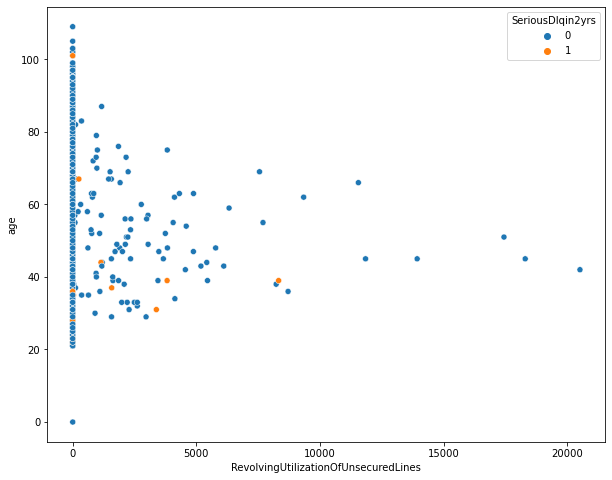

In [13]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'RevolvingUtilizationOfUnsecuredLines', y = 'age', data = train, hue = 'SeriousDlqin2yrs')
plt.show();

In [6]:
pd.crosstab(train['SeriousDlqin2yrs'], train['missing_income'])

missing_income,0,1
SeriousDlqin2yrs,,
0,54732,13699
1,4112,820


In [7]:
4112 / (4112 + 54732)

0.06987968187070899

In [8]:
820 / (13699 + 820)

0.05647771885116055

In [9]:
pd.crosstab(train['SeriousDlqin2yrs'], train['missing_dependents'])

missing_dependents,0,1
SeriousDlqin2yrs,,
0,66579,1852
1,4852,80


In [10]:
4852 / (4852 + 66579)

0.0679256905265221

In [11]:
80 / (80 + 1852)

0.041407867494824016

In [4]:
plt.figure(figsize = (10, 8))


0        False
1        False
2        False
3         True
4         True
         ...  
73358     True
73359     True
73360    False
73361    False
73362    False
Name: MonthlyIncome, Length: 73363, dtype: bool

# Feature Engineering

In [ ]:
train['TotalLoans'] = train['NumberOfOpenCreditLinesAndLoans'] + train['NumberRealEstateLoansOrLines']
train['Late90days'] = np.where(train['NumberOfTimes90DaysLate'] >= 1, 1, 0)
train['Late60_90days'] = np.where(train['NumberOfTime60-89DaysPastDueNotWorse'] >= 1, 1, 0)
train['Late30_50days'] = np.where(train['NumberOfTime60-89DaysPastDueNotWorse'] >= 2, 1, 0)
train['missing_income'] = np.where(np.isnan(train['MonthlyIncome']) == True, 1, 0)
train['missing_dependents'] = np.where(np.isnan(train['NumberOfDependents']) == True, 1, 0)

test['TotalLoans'] = test['NumberOfOpenCreditLinesAndLoans'] + test['NumberRealEstateLoansOrLines']
test['Late90days'] = np.where(test['NumberOfTimes90DaysLate'] >= 1, 1, 0)
test['Late60_90days'] = np.where(test['NumberOfTime60-89DaysPastDueNotWorse'] >= 1, 1, 0)
test['Late30_50days'] = np.where(test['NumberOfTime60-89DaysPastDueNotWorse'] >= 2, 1, 0)
test['missing_income'] = np.where(np.isnan(test['MonthlyIncome']) == True, 1, 0)
test['missing_dependents'] = np.where(np.isnan(test['NumberOfDependents']) == True, 1, 0)

## Filling missing values with kNN
knn_imputer = KNNImputer(n_neighbors = 5, weights = 'distance')
train = pd.DataFrame(knn_imputer.fit_transform(train), columns = train.columns)
test = pd.DataFrame(knn_imputer.fit_transform(test), columns = test.columns)

In [ ]:
## Scaling inputs to 0-1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
test = scaler.fit_transform(test)

## Defining the hyper-parameter grid
logistic_param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],
                       'C': [0.001, 0.01, 0.1, 1, 10, 100],
                       'solver': ['liblinear', 'sag', 'saga']}
#                        'class_weight': ['balanced']}

## Performing grid search with 5 folds
logistic_grid_search = GridSearchCV(LogisticRegression(), logistic_param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = 1).fit(X, Y)

## Extracting the best parameters
best_params = logistic_grid_search.best_params_
print('The optimal hyper-parameters are:', best_params)

## Extracting the best score
best_score = logistic_grid_search.best_score_
print('The best area under the ROC cure is:', best_score)

## Extracting the best model
logistic_md = logistic_grid_search.best_estimator_
